In [15]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage.color import rgba2rgb
from skimage import exposure
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


def load_images(folder):
    images = []
    labels = []
    fruit_mapping = {'apple': 0, 'banana': 1, 'orange': 2}  
    valid_extensions = ('.jpg')  

    for image_filename in os.listdir(folder):
        if not image_filename.lower().endswith(valid_extensions):  
            continue
        image_path = os.path.join(folder, image_filename)
        try:
            img = imread(image_path)
            if img.shape[-1] == 4:
                img = rgba2rgb(img)
            img_resized = resize(img, (100, 100))  
            feature_vector = extract_features(img_resized)
            images.append(feature_vector)
            

            for fruit in fruit_mapping:
                if fruit in image_filename:
                    labels.append(fruit_mapping[fruit])
                    break
        except Exception as e:
            print(f"Error reading {image_path}: {str(e)}")
    return np.array(images), np.array(labels)


def extract_features(image):
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return fd.flatten()


train_data_dir = 'C:\\Users\\shawn\\Downloads\\archive\\train'
test_data_dir = 'C:\\Users\\shawn\\Downloads\\archive\\test'

X_train, y_train = load_images(train_data_dir)
X_test, y_test = load_images(test_data_dir)


scaler = MinMaxScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


classifiers = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}


param_grid = {
    'Random Forest': {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'clf__C': [0.1, 1, 10],
        'clf__gamma': [0.1, 1, 'scale', 'auto'],
        'clf__kernel': ['linear', 'rbf']
    },
    'KNN': {
        'clf__n_neighbors': [3, 5, 10],
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['euclidean', 'manhattan']
    }
}


for clf_name, clf in classifiers.items():
    print(f"For {clf_name}")
    pipeline = Pipeline([
        ('pca', PCA(n_components=50)), 
        ('clf', clf)
    ])

    grid_search = GridSearchCV(pipeline, param_grid[clf_name], n_jobs=-1, verbose=1, cv=3)
    grid_search.fit(X_train_scaled, y_train)


    print(f"Best parameters for {clf_name}:")
    print(grid_search.best_params_)
    print(f"Best cross-validation score for {clf_name}:")
    print(grid_search.best_score_)


    y_pred = grid_search.predict(X_test_scaled)
    print(f"Classification report for {clf_name}:")
    print(classification_report(y_test, y_pred,zero_division=1))
    print("\n")
    


c:\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


For Random Forest
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters for Random Forest:
{'clf__max_depth': 20, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best cross-validation score for Random Forest:
0.6226089102801432
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.56      0.74      0.64        19
           1       0.78      0.78      0.78        18
           2       0.75      0.50      0.60        18

    accuracy                           0.67        55
   macro avg       0.70      0.67      0.67        55
weighted avg       0.69      0.67      0.67        55



For SVM
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters for SVM:
{'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best cross-validation score for SVM:
0.6089102801431568
Classification report for SVM:
              precision    recall  f1-score   su

In [16]:
best_params = {
    'C': 10,
    'gamma': 'scale',
    'kernel': 'rbf'
}

svm_model = Pipeline([
    ('pca', PCA(n_components=50)),  
    ('clf', SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel']))
])


svm_model.fit(X_train_scaled, y_train)


y_pred = svm_model.predict(X_test_scaled)
print("Classification report for SVM:")
print(classification_report(y_test, y_pred, zero_division=1))

Classification report for SVM:
              precision    recall  f1-score   support

           0       0.55      0.63      0.59        19
           1       0.87      0.72      0.79        18
           2       0.67      0.67      0.67        18

    accuracy                           0.67        55
   macro avg       0.69      0.67      0.68        55
weighted avg       0.69      0.67      0.68        55



In [17]:
confusion_matrix=confusion_matrix(y_test,y_pred)
print(confusion_matrix)


[[12  2  5]
 [ 4 13  1]
 [ 6  0 12]]


In [18]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6727272727272727


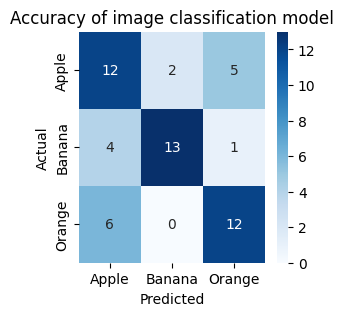

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Apple', 'Banana', 'Orange'],
             yticklabels=['Apple', 'Banana', 'Orange'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Accuracy of image classification model')
plt.show()